
# Titanic dataset with Logistic Regression, XGBoost and CatBoost

For this lecture we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning! 

We'll be trying to predict a classification - survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

We will be training our data on a few models in this notebook:
- Logistic Regression
- RandomizedSearchCV with XGBClassifier
- Hyperopt hyperparameter tuning with XGBClassifier
- GridSearchCV with XGBClassifier
- Custom made Randomised Search for hyperparameter sets using native XGBoost API
- RandomisedSearchCV with CatBoostClassifier

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Import Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [2]:
train = pd.read_csv('titanic_train.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

In [6]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

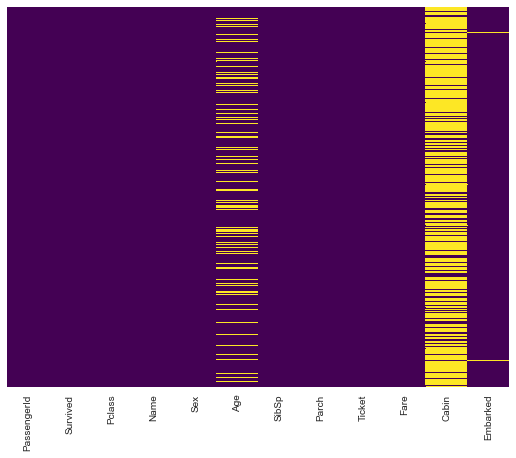

In [81]:
# plot heatmap and use bird's eye view to find the missing data

plt.figure(figsize=(9,7))
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"


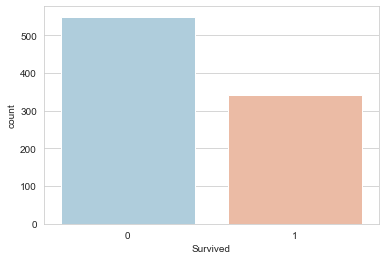

In [82]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

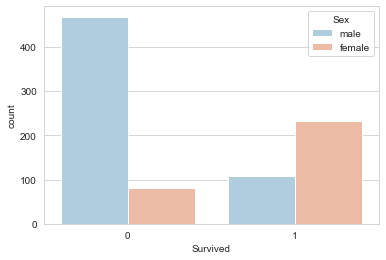

In [83]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

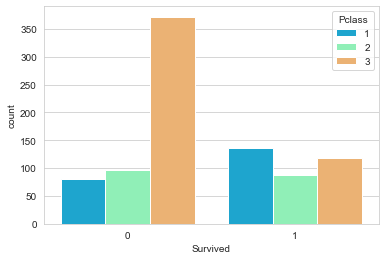

In [84]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

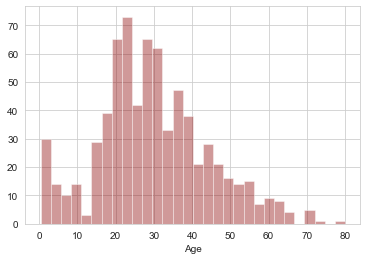

In [85]:
sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

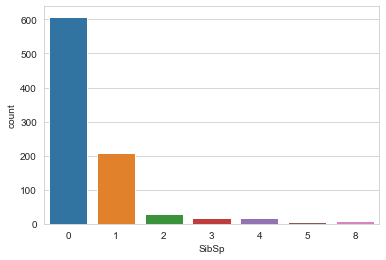

In [86]:
sns.countplot(x='SibSp',data=train)

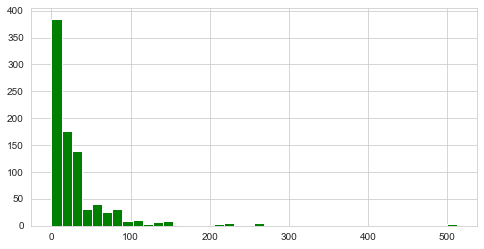

In [87]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

___
## Data Cleaning and Feature Engineering

### Feature Engineering - extract Title from Name

In [6]:
train['Name'].head(20)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

In [7]:
# extract the title in names

train['Name'] = train['Name'].apply(lambda x: x.split(',')[1].split()[0])
train['Name'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Col.           2
Mlle.          2
Major.         2
Sir.           1
Mme.           1
Capt.          1
Don.           1
Jonkheer.      1
Ms.            1
Lady.          1
the            1
Name: Name, dtype: int64

In [8]:
# replace some titles with the same meaning
train.loc[train['Name']=='Mlle.', 'Name'] = 'Miss.'
train.loc[train['Name']=='Ms.', 'Name'] = 'Miss.'
train.loc[train['Name']=='Mme.', 'Name'] = 'Mrs.'

In [9]:
# group rare titles into a category of 'Rare_title'
rare = ('Lady.', 'the','Capt.', 'Col.', 'Don.', 
        'Dr.', 'Major.', 'Rev.', 'Sir.', 'Jonkheer.')

train.loc[train['Name'].isin(rare), 'Name'] = 'Rare_title'

In [10]:
train['Name'].value_counts()

Mr.           517
Miss.         185
Mrs.          126
Master.        40
Rare_title     23
Name: Name, dtype: int64

### Data cleaning - Cabin

In [11]:
train['Cabin'].isnull().sum()   # there are a lot of missing values

687

In [12]:
train['Cabin'].nunique()   # there are many distinct values in Cabin

147

In [13]:
# We will simply split Cabin col into 2 groups - hasCabin / nonCabin

train.loc[train['Cabin'].notnull(), 'Cabin'] = 'hasCabin'
train['Cabin'].fillna('nonCabin', inplace=True)
train['Cabin'].value_counts()

nonCabin    687
hasCabin    204
Name: Cabin, dtype: int64

### Feature Engineering - create Famsize and Famsize_grp feature

In [14]:
# create new feature for Family Size

train['Famsize'] = train['SibSp'] + train['Parch'] + 1
train['Famsize'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: Famsize, dtype: int64

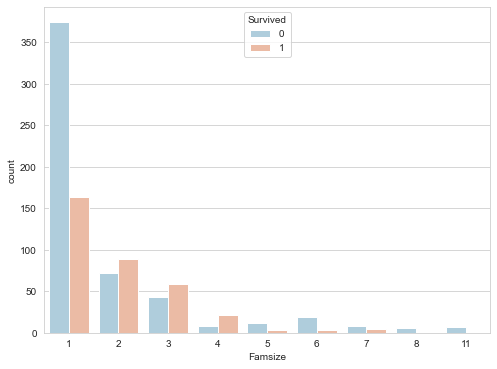

In [15]:
# Plot graph to see the trend in Family size
# We notice that family size of 2,3,4 have higher survival rate than other
# family sizes, it's good to split them into family size groups

plt.figure(figsize=(8,6))
sns.set_style('whitegrid')
sns.countplot(x='Famsize', data=train, palette='RdBu_r', hue='Survived')

In [16]:
# group Famsize into 3 discrete groups

train['Famsize_grp'] = np.where(train['Famsize'] == 1, 'singleton', 
                np.where((train['Famsize'] > 1) & (train['Famsize'] < 5),
                                         'small', 'large'))
train['Famsize_grp'].value_counts()

singleton    537
small        292
large         62
Name: Famsize_grp, dtype: int64

### Impute missing Embarked data

In [17]:
# impute the missing Embarked value

train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         2
Famsize          0
Famsize_grp      0
dtype: int64

In [18]:
train[train['Embarked'].isnull()]   # inspect the missing Embarked cases

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Famsize,Famsize_grp
61,62,1,1,Miss.,female,38.0,0,0,113572,80.0,hasCabin,NaN,1,singleton
829,830,1,1,Mrs.,female,62.0,0,0,113572,80.0,hasCabin,NaN,1,singleton


We will infer their values for embarkment based on present data that we can imagine may be relevant: passenger class and fare. We see that they paid $ 80 and their classes are 1. So from where did they embark?

The median fare for a first class passenger departing from Charbourg (‘C’) coincides nicely with the $80 paid by our embarkment-deficient passengers. I think we can safely replace the NA values with ‘C’.

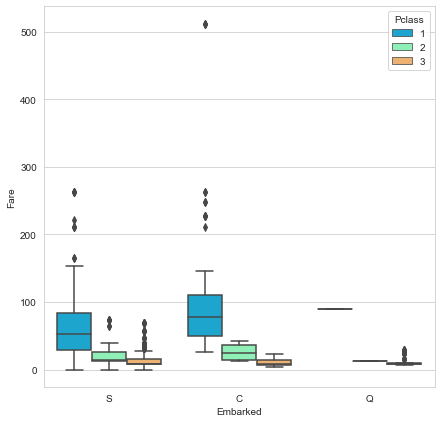

In [19]:
# Boxplot to show the median fare value for each Pclass and Embark location

plt.figure(figsize=(7, 7))
sns.boxplot(x='Embarked',y='Fare',data=train,palette='rainbow',hue='Pclass')

In [20]:
# replace missing Embarked data with port C

train['Embarked'] = train['Embarked'].replace(np.NaN, 'C')
train['Embarked'].isnull().sum()

0

### Impute missing Age data

We want to fill in missing age data instead of just dropping the missing age data rows. 


In [21]:
# make a temp dataframe mice_df to prepare for age imputation
# use get_dummies to convert categorical values to dummy variables

mice_df = pd.get_dummies(train,
    columns=['Name','Embarked','Sex','Famsize_grp'], drop_first=True)
mice_df.drop(['Survived','PassengerId','Ticket','Cabin'],
                axis=1, inplace=True)
mice_df.head()

,Pclass,Age,SibSp,Parch,Fare,Famsize,Name_Miss.,Name_Mr.,Name_Mrs.,Name_Rare_title,Embarked_Q,Embarked_S,Sex_male,Famsize_grp_singleton,Famsize_grp_small
0,3,22.0,1,0,7.2500,2,0,1,0,0,0,1,1,0,1
1,1,38.0,1,0,71.2833,2,0,0,1,0,0,0,0,0,1
2,3,26.0,0,0,7.9250,1,1,0,0,0,0,1,0,1,0
3,1,35.0,1,0,53.1000,2,0,0,1,0,0,1,0,0,1
4,3,35.0,0,0,8.0500,1,0,1,0,0,0,1,1,1,0


In [22]:
# Multiple imputation by chained equations - MICE
# Use MICE to impute age data to keep roughly the same age distribution

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [23]:
imp_mean = IterativeImputer(random_state=0, min_value=1, 
                            estimator=RandomForestRegressor())
temp = imp_mean.fit_transform(mice_df)
temp = pd.DataFrame(temp)   # convert array to dataframe for convenience

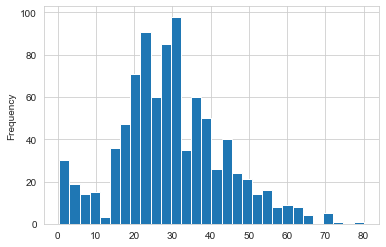

In [24]:
# Plot Age data distribution after imputation, the distribution is 
# roughly the same as original Age data
temp[1].plot.hist(bins=30)

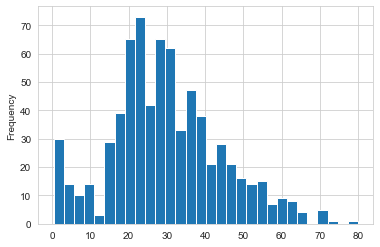

In [25]:
# this graph shows original Age data distribution with missing Age data
train['Age'].plot.hist(bins=30)

In [26]:
train['Age'] = temp[1]     # save the imputed age back to train set
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Famsize        0
Famsize_grp    0
dtype: int64

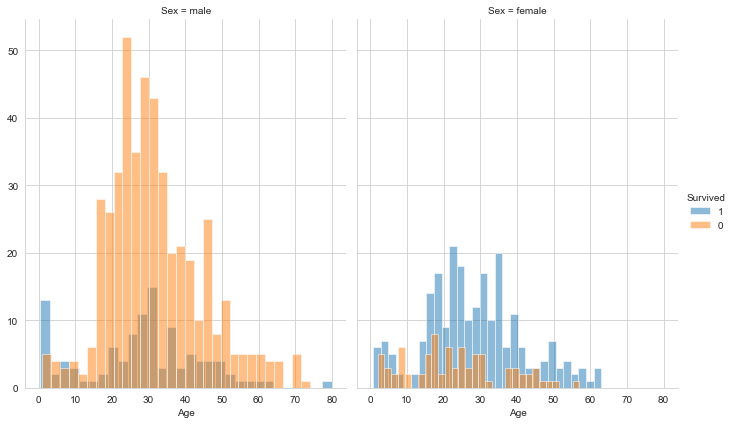

In [109]:
# histogram for Age after imputation

g = sns.FacetGrid(train, col='Sex', hue='Survived', height=6, aspect=0.8, 
                  hue_order=[1, 0], hue_kws={'alpha':[0.5,0.5]})
g = g.map(plt.hist, 'Age', bins=30).add_legend()


### Feature Engineering - create Child and Mother feature

In [27]:
# create new feature for Child - person under age 18

train['Child'] = np.where(train['Age'] < 18, 'Child', 'Adult')
train['Child'].value_counts()

Adult    755
Child    136
Name: Child, dtype: int64

In [28]:
train.groupby(['Child', 'Survived']).count().iloc[:,0]

Child  Survived
Adult  0           481
       1           274
Child  0            68
       1            68
Name: PassengerId, dtype: int64

In [29]:
# create new feature for Mother
# 1) female, 
# 2) over 18, 
# 3) has more than 0 children,
# 4) does not have the title ‘Miss’

train['Mother'] = np.where(
    (train['Sex'] == 'female') & (train['Age'] > 18) 
    & (train['Parch'] > 0) & (train['Name'] != 'Miss.'),
    'Mother', 'Not Mother')
train['Mother'].value_counts()

Not Mother    836
Mother         55
Name: Mother, dtype: int64

In [30]:
train.groupby(['Mother', 'Survived']).count().iloc[:,0]

Mother      Survived
Mother      0            16
            1            39
Not Mother  0           533
            1           303
Name: PassengerId, dtype: int64

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
 12  Famsize      891 non-null    int64  
 13  Famsize_grp  891 non-null    object 
 14  Child        891 non-null    object 
 15  Mother       891 non-null    object 
dtypes: float64(2), int64(6), object(8)
memory usage: 111.5+ KB


In [31]:
logistic_df = pd.get_dummies(train,
    columns=['Name','Sex','Embarked','Cabin','Famsize_grp'], drop_first=True)
logistic_df.drop(['PassengerId','Ticket','Famsize','SibSp','Parch'
                               ,'Child','Mother'], axis=1, inplace=True)
logistic_df.head()


,Survived,Pclass,Age,Fare,Name_Miss.,Name_Mr.,Name_Mrs.,Name_Rare_title,Sex_male,Embarked_Q,Embarked_S,Cabin_nonCabin,Famsize_grp_singleton,Famsize_grp_small
0,0,3,22.0,7.2500,0,1,0,0,1,0,1,1,0,1
1,1,1,38.0,71.2833,0,0,1,0,0,0,0,0,0,1
2,1,3,26.0,7.9250,1,0,0,0,0,0,1,1,1,0
3,1,1,35.0,53.1000,0,0,1,0,0,0,1,0,0,1
4,0,3,35.0,8.0500,0,1,0,0,1,0,1,1,1,0


Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set

## Train Test Split

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(logistic_df.drop('Survived',axis=1), 
                                                    logistic_df['Survived'], test_size=0.3, 
                                                    random_state=122,
                                                    stratify=logistic_df['Survived'])

## Training and Predicting

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
logmodel = LogisticRegression(max_iter=500)
logmodel.fit(X_train,y_train)

LogisticRegression(max_iter=500)

In [35]:
predictions = logmodel.predict(X_test)

Let's move on to evaluate our model!

## Evaluation

In [36]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, predictions), 
             index=['Actual F', 'Actual T'], 
             columns=['Predict F', 'Predict T'])

,Predict F,Predict T
Actual F,146,19
Actual T,19,84


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       165
           1       0.82      0.82      0.82       103

    accuracy                           0.86       268
   macro avg       0.85      0.85      0.85       268
weighted avg       0.86      0.86      0.86       268



In [38]:
logmodel.intercept_

array([2.01974699])

In [39]:
# display the coeff of each parameter to understand their impact to the
# survived prediction

coeff = pd.DataFrame(logmodel.coef_.T, index=X_train.columns, columns=['Coeff'])
coeff.sort_values(by='Coeff', ascending=False, axis=0)

,Coeff
Famsize_grp_singleton,2.055729
Famsize_grp_small,1.757864
Name_Mrs.,0.522790
Embarked_Q,0.225939
Fare,0.002615
Age,-0.022710
Name_Miss.,-0.228485
Embarked_S,-0.248572
Cabin_nonCabin,-0.532445
Pclass,-0.728855


# XGBoost

### Need to convert categorical features to dummy variables for XGBoost

In [40]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Famsize,Famsize_grp,Child,Mother
0,1,0,3,Mr.,male,22.0,1,0,A/5 21171,7.2500,nonCabin,S,2,small,Adult,Not Mother
1,2,1,1,Mrs.,female,38.0,1,0,PC 17599,71.2833,hasCabin,C,2,small,Adult,Not Mother
2,3,1,3,Miss.,female,26.0,0,0,STON/O2. 3101282,7.9250,nonCabin,S,1,singleton,Adult,Not Mother
3,4,1,1,Mrs.,female,35.0,1,0,113803,53.1000,hasCabin,S,2,small,Adult,Not Mother
4,5,0,3,Mr.,male,35.0,0,0,373450,8.0500,nonCabin,S,1,singleton,Adult,Not Mother


In [41]:
# convert categorical features to dummy variables and drop unwanted features

titanic_xgboost_ready_df = pd.get_dummies(train,
    columns=['Name','Embarked','Sex','Cabin'], drop_first=True)
titanic_xgboost_ready_df.drop(['PassengerId','Ticket','SibSp','Parch','Famsize_grp'
                               ,'Child','Mother'], axis=1, inplace=True)
titanic_xgboost_ready_df.head()


,Survived,Pclass,Age,Fare,Famsize,Name_Miss.,Name_Mr.,Name_Mrs.,Name_Rare_title,Embarked_Q,Embarked_S,Sex_male,Cabin_nonCabin
0,0,3,22.0,7.2500,2,0,1,0,0,0,1,1,1
1,1,1,38.0,71.2833,2,0,0,1,0,0,0,0,0
2,1,3,26.0,7.9250,1,1,0,0,0,0,1,0,1
3,1,1,35.0,53.1000,2,0,0,1,0,0,1,0,0
4,0,3,35.0,8.0500,1,0,1,0,0,0,1,1,1


## RandomizedSearchCV with XGBClassifier

In [144]:
from sklearn.model_selection import train_test_split

features = [feat for feat in list(titanic_xgboost_ready_df) if feat != 'Survived']
X_train, X_test, y_train, y_test = train_test_split(titanic_xgboost_ready_df[features],
                                                titanic_xgboost_ready_df['Survived'],
                                                test_size=0.3,
                                                random_state=122,
                                                stratify=titanic_xgboost_ready_df['Survived'])


In [63]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

model = XGBClassifier()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# set the randomised search space for hyperparameters

n_estimators = np.arange(100, 561, 20)
learning_rate = [0.01, 0.03, 0.1, 0.2, 0.3]
max_depth = np.arange(3, 10, 2)
min_child_weight = [1, 3, 5, 7]
subsample = np.arange(0.7, 1.001, 0.01)
colsample_bytree = np.arange(0.7, 1.001, 0.01)
reg_lambda = np.arange(0.5, 1.001, 0.1)
random_state = range(100, 201)

param_grid = dict(n_estimators=n_estimators, max_depth=max_depth,
                 learning_rate=learning_rate,
                 min_child_weight=min_child_weight,
                 subsample=subsample,
                 colsample_bytree=colsample_bytree,
                 reg_lambda=reg_lambda,
                 random_state=random_state)  

# randomly sample 200 hyperparameter sets from the search space and 
# train the XGBClassifier

random_search = RandomizedSearchCV(model, param_grid, cv=kfold, n_jobs=-1,
                                  scoring='accuracy', n_iter=200,
                                  verbose=1)
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   32.6s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, m...
                                        'n_estimators': array([100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340,
       360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560]),
                                        'random_state': range(100, 201),
  

In [64]:
randparam = random_search.best_params_
randparam     # check out the best hyperparam set from randomised search

{'subsample': 0.8800000000000001,
 'reg_lambda': 0.6,
 'random_state': 146,
 'n_estimators': 200,
 'min_child_weight': 7,
 'max_depth': 7,
 'learning_rate': 0.1,
 'colsample_bytree': 0.81}

In [65]:
# return the highest accuracy score with this hyperparam set
random_search.best_score_  

0.8217548387096774

In [66]:
max_idx = random_search.cv_results_['mean_test_score'].argmax()
max_idx

163

In [67]:
# examine the accuracy score for 5 split folds that average to the 
# best score for the hyperparam set
for n in range(5):
    print(random_search.cv_results_[f'split{n}_test_score'][max_idx])    

0.816
0.808
0.888
0.8145161290322581
0.782258064516129


In [68]:
pred = random_search.predict(X_test)
pred[:5]

array([0, 1, 0, 0, 0])

[[154  11]
 [ 15  88]]


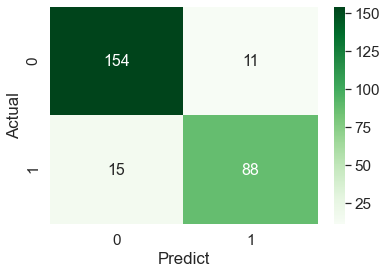

In [69]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

plt.figure(figsize = (6,4))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g',cmap='Greens')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       165
           1       0.89      0.85      0.87       103

    accuracy                           0.90       268
   macro avg       0.90      0.89      0.90       268
weighted avg       0.90      0.90      0.90       268



### Train XGBClassifier again with best params from Randomised Search

In [71]:
randparam

{'subsample': 0.8800000000000001,
 'reg_lambda': 0.6,
 'random_state': 146,
 'n_estimators': 200,
 'min_child_weight': 7,
 'max_depth': 7,
 'learning_rate': 0.1,
 'colsample_bytree': 0.81}

In [83]:
clf = XGBClassifier(**randparam)

# clf.set_params(n_estimators=200)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.81, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=7,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              random_state=146, reg_alpha=None, reg_lambda=0.6,
              scale_pos_weight=None, subsample=0.8800000000000001,
              tree_method=None, validate_parameters=False, verbosity=None)

In [84]:
clf.fit(X_train, y_train, #early_stopping_rounds=200,
        eval_set=[(X_test, y_test)],
        eval_metric='error', verbose=20)

[0]	validation_0-error:0.21269
[20]	validation_0-error:0.13433
[40]	validation_0-error:0.12687
[60]	validation_0-error:0.12313
[80]	validation_0-error:0.12313
[100]	validation_0-error:0.11940
[120]	validation_0-error:0.11194
[140]	validation_0-error:0.11194
[160]	validation_0-error:0.10075
[180]	validation_0-error:0.10075
[199]	validation_0-error:0.09702


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.81, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=146,
              reg_alpha=0, reg_lambda=0.6, scale_pos_weight=1,
              subsample=0.8800000000000001, tree_method=None,
              validate_parameters=False, verbosity=None)

In [85]:
pred = clf.predict(X_test)
pred[:5]

array([0, 1, 0, 0, 0])

In [86]:
clf.score(X_test, y_test)   # return test accuracy

0.9029850746268657

[[154  11]
 [ 15  88]]


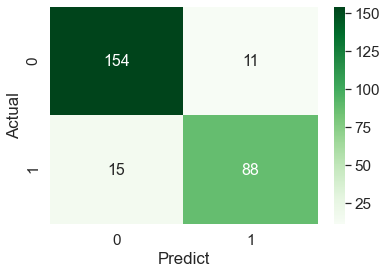

In [87]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

plt.figure(figsize = (6,4))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g',cmap='Greens')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [88]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       165
           1       0.89      0.85      0.87       103

    accuracy                           0.90       268
   macro avg       0.90      0.89      0.90       268
weighted avg       0.90      0.90      0.90       268



In [162]:
# save the xgboost model to a file for later retrieval 
clf.save_model('xgbmodel.model')

In [168]:
# load a xgboost model from file and make predictions

# clf_from_file = XGBClassifier()
# clf_from_file.load_model('xgbmodel.model')
# clf_from_file.predict(X_test)[:5]

## Hyperopt - hyperparameter tuning with XGBClassifier

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [70]:
# Define objective function

def objective_function(space):
    clf = XGBClassifier(
        max_depth = int(space['max_depth']),
        gamma = space['gamma'],
        reg_alpha = int(space['reg_alpha']),
        reg_lambda = space['reg_lambda'],
        colsample_bytree = space['colsample_bytree'],
        min_child_weight = int(space['min_child_weight']),
        learning_rate = space['learning_rate'],
        n_estimators = int(space['n_estimators']),
        subsample = space['subsample'],
        random_state = int(space['random_state'])
    )

    score = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1,
                           scoring='accuracy').mean()
    print("SCORE:", score)
    return {'loss': -score, 'status': STATUS_OK }

In [71]:
# Create domain space for sampling hyperparameters

space= {'max_depth': hp.quniform("max_depth", 3, 15, 1),
        'gamma': hp.uniform ('gamma', 0,5),
        'reg_alpha' : hp.quniform('reg_alpha', 0,120,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.6,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
        'n_estimators': hp.quniform('n_estimators', 30, 501, 1),
        'subsample' : hp.uniform('subsample', 0.6,1),
        'random_state': hp.quniform('random_state', 100, 201, 1)
       }

In [72]:
trials = Trials()

In [73]:
# Run optimisation algorithm

best_hyperparams = fmin(fn = objective_function,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)

SCORE:                                                 
0.6163741935483871                                     
SCORE:                                                                            
0.6163741935483871                                                                
SCORE:                                                                            
0.6163741935483871                                                                
SCORE:                                                                            
0.6163741935483871                                                                
SCORE:                                                                            
0.7929935483870969                                                                
SCORE:                                                                            
0.6163741935483871                                                                
SCORE:                                                    

0.8057935483870968                                                                 
SCORE:                                                                             
0.788141935483871                                                                  
SCORE:                                                                             
0.6163741935483871                                                                 
SCORE:                                                                              
0.7833419354838711                                                                  
SCORE:                                                                              
0.6163741935483871                                                                  
SCORE:                                                                              
0.7446322580645162                                                                  
SCORE:                                                                

0.6163741935483871                                                                  
SCORE:                                                                              
0.8025161290322581                                                                  
SCORE:                                                                              
0.7945806451612903                                                                  
SCORE:                                                                              
0.8026451612903227                                                                  
SCORE:                                                                              
0.6260516129032258                                                                  
SCORE:                                                                              
0.8138322580645163                                                                  
SCORE:                                                           

In [74]:
print(best_hyperparams)

{'colsample_bytree': 0.879012625320015, 'gamma': 0.5018877839396907, 'learning_rate': 0.027675060778152582, 'max_depth': 6.0, 'min_child_weight': 0.0, 'n_estimators': 199.0, 'random_state': 190.0, 'reg_alpha': 0.0, 'reg_lambda': 0.8274543000029477, 'subsample': 0.7666996914497989}


In [75]:
trials.best_trial

{'state': 2,
 'tid': 119,
 'spec': None,
 'result': {'loss': -0.8201677419354839, 'status': 'ok'},
 'misc': {'tid': 119,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [119],
   'gamma': [119],
   'learning_rate': [119],
   'max_depth': [119],
   'min_child_weight': [119],
   'n_estimators': [119],
   'random_state': [119],
   'reg_alpha': [119],
   'reg_lambda': [119],
   'subsample': [119]},
  'vals': {'colsample_bytree': [0.879012625320015],
   'gamma': [0.5018877839396907],
   'learning_rate': [0.027675060778152582],
   'max_depth': [6.0],
   'min_child_weight': [0.0],
   'n_estimators': [199.0],
   'random_state': [190.0],
   'reg_alpha': [0.0],
   'reg_lambda': [0.8274543000029477],
   'subsample': [0.7666996914497989]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2020, 6, 8, 3, 55, 10, 263000),
 'refresh_time': datetime.datetime(2020, 6, 8, 3, 55, 10, 432000)}

### Train XGBClassifier again with best hyperparams from Hyperopt

In [76]:
clf = XGBClassifier(
        max_depth = int(best_hyperparams['max_depth']),
        gamma = best_hyperparams['gamma'],
        reg_alpha = int(best_hyperparams['reg_alpha']),
        reg_lambda = best_hyperparams['reg_lambda'],
        colsample_bytree = best_hyperparams['colsample_bytree'],
        min_child_weight = int(best_hyperparams['min_child_weight']),
        learning_rate = best_hyperparams['learning_rate'],
        n_estimators = int(best_hyperparams['n_estimators']),
        subsample = best_hyperparams['subsample'],
        random_state = int(best_hyperparams['random_state'])
)

# clf.set_params(n_estimators=5000)

In [77]:
clf.fit(X_train, y_train, 
        eval_set=[(X_test, y_test)],
        eval_metric='error', verbose=20)

[0]	validation_0-error:0.16418
[20]	validation_0-error:0.12313
[40]	validation_0-error:0.11194
[60]	validation_0-error:0.10821
[80]	validation_0-error:0.10448
[100]	validation_0-error:0.10448
[120]	validation_0-error:0.09702
[140]	validation_0-error:0.09702
[160]	validation_0-error:0.09328
[180]	validation_0-error:0.09328
[198]	validation_0-error:0.08955


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.879012625320015,
              gamma=0.5018877839396907, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.027675060778152582,
              max_delta_step=0, max_depth=6, min_child_weight=0, missing=nan,
              monotone_constraints=None, n_estimators=199, n_jobs=0,
              num_parallel_tree=1, random_state=190, reg_alpha=0,
              reg_lambda=0.8274543000029477, scale_pos_weight=1,
              subsample=0.7666996914497989, tree_method=None,
              validate_parameters=False, verbosity=None)

In [78]:
pred = clf.predict(X_test)
pred[:5]

array([0, 1, 0, 0, 0])

In [79]:
clf.score(X_test, y_test)   # return test accuracy

0.9104477611940298

[[156   9]
 [ 15  88]]


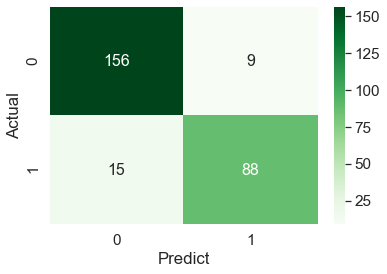

In [80]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

plt.figure(figsize = (6,4))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g',cmap='Greens')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [81]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       165
           1       0.91      0.85      0.88       103

    accuracy                           0.91       268
   macro avg       0.91      0.90      0.90       268
weighted avg       0.91      0.91      0.91       268



## GridSearchCV with XGBClassifier

In [42]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

model = XGBClassifier()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# The number of hyperparameter combinations can exponentially increase 
# as we add more hyperparameters to tune in GridSearchCV, it will take
# some time and requires computational resource

n_estimators = range(200, 501, 50)
learning_rate = [0.01, 0.03, 0.1] 
max_depth = [3, 5, 7, 9]
min_child_weight = [3, 5, 7, 9]
subsample = [0.8, 1.0]
colsample_bytree = [0.8, 1.0]
random_state = [128]

param_grid = dict(n_estimators=n_estimators, max_depth=max_depth,
                 learning_rate=learning_rate,
                 min_child_weight=min_child_weight,
                 subsample=subsample,
                 colsample_bytree=colsample_bytree,
                 random_state=random_state)  

grid = GridSearchCV(model, param_grid, refit=True, verbose=1, cv=kfold,
                   n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)


Fitting 5 folds for each of 1344 candidates, totalling 6720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 6720 out of 6720 | elapsed:  4.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
  

In [45]:
grid_param = grid.best_params_
grid_param

{'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 7,
 'n_estimators': 250,
 'random_state': 128,
 'subsample': 0.8}

In [46]:
grid.best_estimator_  # gives all the params for the model

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=0, num_parallel_tree=1, random_state=128,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

In [47]:
grid.best_score_   # display the highest average accuracy score

0.8297677419354839

In [48]:
pred = grid.predict(X_test)
pred[:5]

array([0, 1, 0, 0, 0])

[[153  12]
 [ 15  88]]


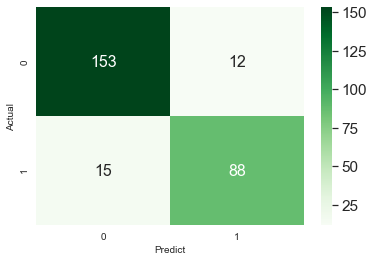

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

plt.figure(figsize = (6,4))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g',cmap='Greens')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       165
           1       0.88      0.85      0.87       103

    accuracy                           0.90       268
   macro avg       0.90      0.89      0.89       268
weighted avg       0.90      0.90      0.90       268



### Train XGBClassifier again with best params from GridSearchCV

In [51]:
clf = XGBClassifier(**grid_param)

In [52]:
clf.fit(X_train, y_train, 
        eval_set=[(X_test, y_test)],
        eval_metric='error', verbose=20)

[0]	validation_0-error:0.16418
[20]	validation_0-error:0.14552
[40]	validation_0-error:0.14552
[60]	validation_0-error:0.13060
[80]	validation_0-error:0.12687
[100]	validation_0-error:0.12313
[120]	validation_0-error:0.10821
[140]	validation_0-error:0.10075
[160]	validation_0-error:0.10075
[180]	validation_0-error:0.10075
[200]	validation_0-error:0.10075
[220]	validation_0-error:0.09702
[240]	validation_0-error:0.10075
[249]	validation_0-error:0.10075


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=0, num_parallel_tree=1, random_state=128,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

In [53]:
pred = clf.predict(X_test)
pred[:5]

array([0, 1, 0, 0, 0])

In [54]:
clf.score(X_test, y_test)   # return test accuracy

0.8992537313432836

[[153  12]
 [ 15  88]]


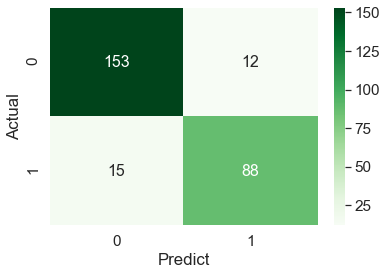

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

plt.figure(figsize = (6,4))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g',cmap='Greens')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [56]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       165
           1       0.88      0.85      0.87       103

    accuracy                           0.90       268
   macro avg       0.90      0.89      0.89       268
weighted avg       0.90      0.90      0.90       268



## Custom made Randomised Search for hyperparam 
## sets using native XGBoost API - xgb.cv()

In [214]:
# custom make 500 random search from below hyperparam sets in XGBoost
# np.random.seed(42)

param_list = []
for n in range(500):
    params = {
        'max_depth': np.random.choice((3,4,5,6,7,8,9)),  
        'min_child_weight': np.random.choice((0,1,2,3,4,5,6,7,8,9)),
        'eta':np.random.randint(1,31)/100,
        'subsample': np.random.randint(70,101)/100,
        'colsample_bytree': np.random.randint(70,101)/100,
        'reg_lambda' : np.random.randint(5,11)/10,
        'eval_metric':'error',
        'objective':'binary:logistic',
        'seed' : np.random.randint(100,201)
    }
    param_list.append(params)

In [215]:
param_list[0]  # preview one set of the randomly generated hyperparameters

{'max_depth': 3,
 'min_child_weight': 1,
 'eta': 0.18,
 'subsample': 0.87,
 'colsample_bytree': 0.77,
 'reg_lambda': 0.5,
 'eval_metric': 'error',
 'objective': 'binary:logistic',
 'seed': 118}

In [216]:
%%time

# train XGBoost model using xgb.train() for 500 random hyperparam sets

import xgboost as xgb
from sklearn.model_selection import train_test_split

SEED = 122    # Set the seed

features = [feat for feat in list(titanic_xgboost_ready_df) if feat != 'Survived']
X_train, X_test, y_train, y_test = train_test_split(titanic_xgboost_ready_df[features], 
                                                titanic_xgboost_ready_df['Survived'], 
                                                test_size=0.3, 
                                                random_state=SEED,
                                                stratify=titanic_xgboost_ready_df['Survived'])

# Prepare the DMatrix object from train set and test set as inupt to 
# the native xgboost API
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
dtest = xgb.DMatrix(X_test, y_test, feature_names=X_test.columns.values)

# create empty list to store result for each hyperparam set
val_loss = []
boost_round = []

for n in range(len(param_list)):
    cv_results = xgb.cv( params = param_list[n],
                  dtrain = dtrain,
                  num_boost_round = 5000,
                  early_stopping_rounds = 50,
#                   seed=SEED,  # can set seed value to control CV split
                  nfold=5,
                  stratified=True,
                  metrics='error',
                  verbose_eval=False,
                  maximize = False)
    val_loss.append(cv_results['test-error-mean'].min())
    boost_round.append(cv_results['test-error-mean'].idxmin())

CPU times: user 11min 22s, sys: 18.6 s, total: 11min 41s
Wall time: 1min 31s


In [217]:
cv_results  # preview the last model result in a table

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.159310,0.005755,0.234426,0.035399
1,0.145267,0.009492,0.216761,0.035137
2,0.144461,0.007037,0.218374,0.039470
3,0.140851,0.006152,0.208697,0.040312
4,0.140452,0.007341,0.210310,0.032017
5,0.136841,0.010914,0.207110,0.029162
6,0.136438,0.010797,0.208710,0.025649
7,0.133629,0.011554,0.202271,0.026174
8,0.130418,0.007072,0.208671,0.028641
9,0.130018,0.010970,0.205484,0.027270


In [218]:
# Print the result of the lowest average error among all hyperparam sets
val_loss = np.array(val_loss)
min_loss_idx = val_loss.argmin()

print(f'The lowest average error: {val_loss.min()}')
print(f'The index of this lowest error: {min_loss_idx}')
print(f'The optimum num_boost_round: {boost_round[min_loss_idx]}')

The lowest average error: 0.1686064
The index of this lowest error: 366
The optimum num_boost_round: 167


In [219]:
val_loss.max()   # also check out the highest average error

0.2006452

In [220]:
# display the hyperparam set with the lowest average error
param_list[min_loss_idx]

{'max_depth': 7,
 'min_child_weight': 8,
 'eta': 0.28,
 'subsample': 0.84,
 'colsample_bytree': 0.9,
 'reg_lambda': 0.5,
 'eval_metric': 'error',
 'objective': 'binary:logistic',
 'seed': 124}

### Train native XGBoost API - xgb.train() again with best hyperparams from Custom Randomised Search

In [222]:
evals = [(dtrain,'train'), (dtest,'eval')]

xgb_model = xgb.train( params = param_list[min_loss_idx],
              dtrain = dtrain,
              num_boost_round = boost_round[min_loss_idx],
              verbose_eval=20, 
              evals=evals,
              maximize = False)

[0]	train-error:0.22632	eval-error:0.20522
[20]	train-error:0.15409	eval-error:0.14925
[40]	train-error:0.12520	eval-error:0.10075
[60]	train-error:0.11396	eval-error:0.10821
[80]	train-error:0.11396	eval-error:0.10448
[100]	train-error:0.10273	eval-error:0.10448
[120]	train-error:0.09791	eval-error:0.10448
[140]	train-error:0.09470	eval-error:0.10448
[160]	train-error:0.08507	eval-error:0.10448
[166]	train-error:0.08989	eval-error:0.10075


[[152  13]
 [ 14  89]]


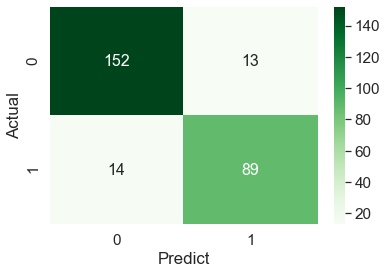

In [223]:
# Confusion matrix
dval_predictions = xgb_model.predict(dtest)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, [1 if p > 0.5 else 0 for p in dval_predictions])
print(cm)

plt.figure(figsize = (6,4))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g',cmap='Greens')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [224]:
from sklearn.metrics import classification_report
print(classification_report(y_test,[1 if p > 0.5 else 0 for p in dval_predictions]))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       165
           1       0.87      0.86      0.87       103

    accuracy                           0.90       268
   macro avg       0.89      0.89      0.89       268
weighted avg       0.90      0.90      0.90       268



In [225]:
# get dataframe version of feature importance for model 
xgb_fea_imp=pd.DataFrame(list(xgb_model.get_fscore().items()),
        columns=['feature','importance']).sort_values(by='importance', 
                                                      ascending=False)
xgb_fea_imp.head(10)

,feature,importance
1,Fare,365
3,Age,301
2,Famsize,38
5,Pclass,37
6,Name_Mr.,28
0,Sex_male,24
4,Cabin_nonCabin,19
7,Embarked_S,18
9,Name_Miss.,14
8,Name_Mrs.,8


# CatBoost

### CatBoost will handle the categorical features when explicitly specified before training the model

In [89]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Famsize,Famsize_grp,Child,Mother
0,1,0,3,Mr.,male,22.0,1,0,A/5 21171,7.2500,nonCabin,S,2,small,Adult,Not Mother
1,2,1,1,Mrs.,female,38.0,1,0,PC 17599,71.2833,hasCabin,C,2,small,Adult,Not Mother
2,3,1,3,Miss.,female,26.0,0,0,STON/O2. 3101282,7.9250,nonCabin,S,1,singleton,Adult,Not Mother
3,4,1,1,Mrs.,female,35.0,1,0,113803,53.1000,hasCabin,S,2,small,Adult,Not Mother
4,5,0,3,Mr.,male,35.0,0,0,373450,8.0500,nonCabin,S,1,singleton,Adult,Not Mother


In [90]:
# keep a list of the features that we are going to train in catboost
features = list(train.drop(['Survived','PassengerId','Ticket',
                           'SibSp','Parch','Child','Mother','Famsize'], 
                           axis=1))
train[features].head()

,Pclass,Name,Sex,Age,Fare,Cabin,Embarked,Famsize_grp
0,3,Mr.,male,22.0,7.2500,nonCabin,S,small
1,1,Mrs.,female,38.0,71.2833,hasCabin,C,small
2,3,Miss.,female,26.0,7.9250,nonCabin,S,singleton
3,1,Mrs.,female,35.0,53.1000,hasCabin,S,small
4,3,Mr.,male,35.0,8.0500,nonCabin,S,singleton


In [91]:
# build an array of categorical feature indices to feed into catboost
titanic_categories = np.where(np.isin(features, ['Age', 'Fare'], 
                                      invert=True))[0]
titanic_categories

array([0, 1, 2, 5, 6, 7])

### CatBoostClassifier.randomized_search() function

In [94]:
# Set the seed
SEED = 122

In [95]:
from catboost import CatBoostClassifier, cv, Pool
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train[features], 
                                                    train['Survived'], 
                                                    test_size=0.3, 
                                                    random_state=SEED,
                                                    stratify=train['Survived']) 


In [96]:
# Do a randomized search in the hyperparameter space

params = {'iterations': np.arange(50, 551, 20),
        'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3],
        'depth': np.arange(3, 10, 2),
        'min_child_samples': [1, 3, 5, 7],
        'subsample': np.arange(0.7, 1.001, 0.01),
        'rsm': np.arange(0.7, 1.001, 0.01), # similar to colsample_bylevel
        'l2_leaf_reg': np.arange(0.5, 1.001, 0.1),
        'random_seed': np.arange(100, 201)
         }

model = CatBoostClassifier(loss_function='Logloss', 
                           eval_metric='Accuracy',
                           cat_features=titanic_categories)

result = model.randomized_search(params, 
                            partition_random_seed=np.random.randint(1000),
                                 X=X_train, y=y_train,
                                 cv=5, n_iter=200, stratified=True)


0:	loss: 0.8480000	best: 0.8480000 (0)	total: 188ms	remaining: 37.5s
1:	loss: 0.8400000	best: 0.8480000 (0)	total: 237ms	remaining: 23.5s
2:	loss: 0.8560000	best: 0.8560000 (2)	total: 659ms	remaining: 43.3s
3:	loss: 0.8560000	best: 0.8560000 (2)	total: 1.02s	remaining: 50.2s
4:	loss: 0.8480000	best: 0.8560000 (2)	total: 1.51s	remaining: 58.8s
5:	loss: 0.8480000	best: 0.8560000 (2)	total: 2.03s	remaining: 1m 5s
6:	loss: 0.8800000	best: 0.8800000 (6)	total: 2.91s	remaining: 1m 20s
7:	loss: 0.8560000	best: 0.8800000 (6)	total: 3.54s	remaining: 1m 25s
8:	loss: 0.8560000	best: 0.8800000 (6)	total: 6.06s	remaining: 2m 8s
9:	loss: 0.8480000	best: 0.8800000 (6)	total: 6.62s	remaining: 2m 5s
10:	loss: 0.8480000	best: 0.8800000 (6)	total: 11s	remaining: 3m 8s
11:	loss: 0.8640000	best: 0.8800000 (6)	total: 15.1s	remaining: 3m 56s
12:	loss: 0.8480000	best: 0.8800000 (6)	total: 15.1s	remaining: 3m 37s
13:	loss: 0.8480000	best: 0.8800000 (6)	total: 15.2s	remaining: 3m 22s
14:	loss: 0.8480000	best: 0

117:	loss: 0.8560000	best: 0.8800000 (6)	total: 1m 43s	remaining: 1m 12s
118:	loss: 0.8480000	best: 0.8800000 (6)	total: 1m 44s	remaining: 1m 11s
119:	loss: 0.8640000	best: 0.8800000 (6)	total: 1m 46s	remaining: 1m 10s
120:	loss: 0.8640000	best: 0.8800000 (6)	total: 1m 47s	remaining: 1m 9s
121:	loss: 0.8480000	best: 0.8800000 (6)	total: 1m 47s	remaining: 1m 8s
122:	loss: 0.8560000	best: 0.8800000 (6)	total: 1m 48s	remaining: 1m 7s
123:	loss: 0.8320000	best: 0.8800000 (6)	total: 1m 48s	remaining: 1m 6s
124:	loss: 0.8560000	best: 0.8800000 (6)	total: 1m 48s	remaining: 1m 5s
125:	loss: 0.8480000	best: 0.8800000 (6)	total: 1m 48s	remaining: 1m 3s
126:	loss: 0.8720000	best: 0.8800000 (6)	total: 1m 49s	remaining: 1m 2s
127:	loss: 0.8480000	best: 0.8800000 (6)	total: 1m 49s	remaining: 1m 1s
128:	loss: 0.8560000	best: 0.8800000 (6)	total: 1m 51s	remaining: 1m 1s
129:	loss: 0.8480000	best: 0.8800000 (6)	total: 1m 51s	remaining: 1m
130:	loss: 0.8560000	best: 0.8800000 (6)	total: 1m 52s	remaining

In [97]:
best_param = result['params']
best_param

{'min_data_in_leaf': 5,
 'random_seed': 193,
 'depth': 5,
 'iterations': 410,
 'subsample': 0.73,
 'rsm': 0.7,
 'learning_rate': 0.1,
 'l2_leaf_reg': 0.5}

In [98]:
cat_pred = model.predict(X_test)
cat_pred[:5]

array([0, 1, 0, 0, 0])

In [99]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, cat_pred)

0.8917910447761194

[[150  15]
 [ 14  89]]


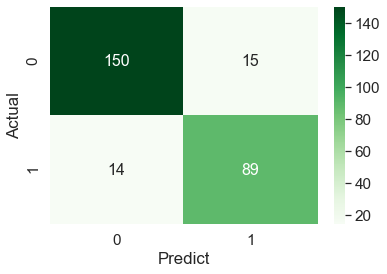

In [100]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, cat_pred)
print(cm)

plt.figure(figsize = (6,4))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g',cmap='Greens')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

### Train CatBoostClassifier again with best params from randomized_search() function

In [101]:
best_param['loss_function'] = 'Logloss'
best_param['eval_metric'] = 'Accuracy'
best_param

{'min_data_in_leaf': 5,
 'random_seed': 193,
 'depth': 5,
 'iterations': 410,
 'subsample': 0.73,
 'rsm': 0.7,
 'learning_rate': 0.1,
 'l2_leaf_reg': 0.5,
 'loss_function': 'Logloss',
 'eval_metric': 'Accuracy'}

In [102]:
cat_model = CatBoostClassifier(cat_features=titanic_categories,
                               verbose=100,
                               **best_param)
cat_model.fit(X_train, y_train)

0:	learn: 0.8105939	total: 3.26ms	remaining: 1.33s
100:	learn: 0.8860353	total: 224ms	remaining: 685ms
200:	learn: 0.9470305	total: 416ms	remaining: 432ms
300:	learn: 0.9678973	total: 624ms	remaining: 226ms
400:	learn: 0.9887640	total: 852ms	remaining: 19.1ms
409:	learn: 0.9887640	total: 878ms	remaining: 0us


[[150  15]
 [ 14  89]]


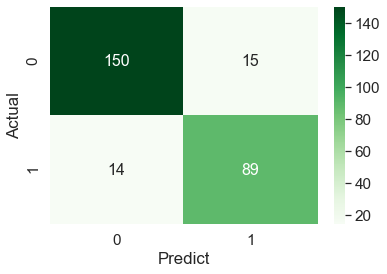

In [108]:
# Confusion matrix
dval_predictions = cat_model.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, dval_predictions)
print(cm)

plt.figure(figsize = (6,4))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g',cmap='Greens')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [104]:
from sklearn.metrics import classification_report
print(classification_report(y_test, dval_predictions))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       165
           1       0.86      0.86      0.86       103

    accuracy                           0.89       268
   macro avg       0.89      0.89      0.89       268
weighted avg       0.89      0.89      0.89       268



In [105]:
cat_model.get_feature_importance()

array([13.57182252, 15.56787507,  5.44580672, 21.78909964, 18.04362237,
        3.24183426, 10.09419708, 12.24574234])

In [106]:
# create a feature importance table in descending order

feat_import = [t for t in zip(features, cat_model.get_feature_importance())]
feat_import_df = pd.DataFrame(feat_import, columns=['Feature', 'VarImp'])
feat_import_df = feat_import_df.sort_values('VarImp', ascending=False)
feat_import_df[feat_import_df['VarImp'] > 0]

,Feature,VarImp
3,Age,21.789100
4,Fare,18.043622
1,Name,15.567875
0,Pclass,13.571823
7,Famsize_grp,12.245742
6,Embarked,10.094197
2,Sex,5.445807
5,Cabin,3.241834


In [131]:
# save the catboost model to a file for later retrieval 
cat_model.save_model('catmodel')

In [135]:
# load a catboost model from file and make predictions

# model_from_file = CatBoostClassifier()
# model_from_file.load_model('catmodel')
# model_from_file.predict(X_test)[:5]

### RandomisedSearchCV with CatBoostClassifier  

In [423]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

model = CatBoostClassifier(loss_function='Logloss', 
                           eval_metric='Accuracy',
                           verbose=False,
                           cat_features=titanic_categories)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# set the randomised search space for hyperparameters

params = {'iterations': np.arange(100, 561, 20),
          'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
        'depth': np.arange(3, 10, 2),
        'min_child_samples': [1, 3, 5, 7],
        'subsample': np.arange(0.7, 1.001, 0.01),
        'rsm': np.arange(0.7, 1.001, 0.01), # similar to colsample_bylevel
        'l2_leaf_reg': np.arange(0.5, 1.001, 0.1),
        'random_seed': np.arange(100, 201)
         }

# randomly sample 200 hyperparameter sets from the search space and 
# train the CatBoostClassifier
# Note that it will take quite some processing time to run through the  
# 200 hyperparam sets in RandomizedSearchCV with CatBoostClassifier

random_search = RandomizedSearchCV(model, params, cv=kfold, n_jobs=-1,
                                  scoring='accuracy', n_iter=200,
                                  verbose=1)
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 34.2min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x12fba8b38>,
                   n_iter=200, n_jobs=-1,
                   param_distributions={'depth': array([3, 5, 7, 9]),
                                        'iterations': array([100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340,
       360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560]),
                                        'l2_leaf_reg': array([0....
                                        'rsm': array([0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ,
       0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91,
       0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ]),
                                        'subsample': array([0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ,
       0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91,
       

In [424]:
randparam = random_search.best_params_
randparam     # check out the best hyperparam set from randomised search

{'subsample': 0.9600000000000002,
 'rsm': 0.8600000000000001,
 'random_seed': 189,
 'min_child_samples': 5,
 'learning_rate': 0.05,
 'l2_leaf_reg': 0.7,
 'iterations': 380,
 'depth': 3}

In [425]:
# return the highest accuracy score with this hyperparam set
random_search.best_score_  

0.8281806451612903

In [426]:
max_idx = random_search.cv_results_['mean_test_score'].argmax()
max_idx

47

In [427]:
# examine the accuracy score for 5 split folds that average to the 
# best score for the hyperparam set
for n in range(5):
    print(random_search.cv_results_[f'split{n}_test_score'][max_idx])    

0.824
0.848
0.856
0.8145161290322581
0.7983870967741935


In [428]:
pred = random_search.predict(X_test)
pred[:5]

array([0, 1, 0, 0, 0])

[[149  16]
 [ 18  85]]


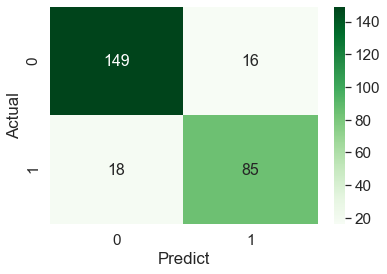

In [429]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

plt.figure(figsize = (6,4))
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g',cmap='Greens')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [430]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       165
           1       0.84      0.83      0.83       103

    accuracy                           0.87       268
   macro avg       0.87      0.86      0.87       268
weighted avg       0.87      0.87      0.87       268

